# Read Data

In [2]:
import time # Log time
start_time = time.time()

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # for plotting
import seaborn as sns; sns.set() # for plotting 
from IPython.display import display
import warnings
warnings.filterwarnings("ignore") # To ignore warning messages while executing the code.

import tqdm
from tqdm import tqdm_notebook as tqdm
tqdm().pandas()

# Data preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

# SK-learn libraries for evaluation.
from sklearn import metrics 
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

# NLP libraries
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
import spacy

# Deep Learning frameworks
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding
from keras.layers import LSTM
from keras.layers import Input
from keras.layers import Conv1D
from keras.layers import MaxPooling1D
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import Dense
from keras.optimizers import RMSprop
from keras.models import Model
from keras.models import load_model



MAX_NUM_WORDS = 10000
TOXICITY_COLUMN = 'target'
TEXT_COLUMN = 'comment_text'

import os


Using TensorFlow backend.


In [3]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [4]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 6839186307946045153, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 4908543434486403812
 physical_device_desc: "device: XLA_CPU device", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 7883103252082885409
 physical_device_desc: "device: XLA_GPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14254804173
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 6269241640313609940
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"]

In [5]:
# Run this cell to mount your Google Drive.
from google.colab import drive
drive.mount('/content/drive')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:

DRIVE_PATH = "/content/drive/My Drive/Jigsaw"

print(os.listdir(DRIVE_PATH))


['preprocessed_data_boolean.csv', 'glove.6B.50d.txt', 'keras_LSTM_glove_300D.h5', 'train_df.csv', 'validate_df.csv', 'tokenizer.p', 'predicted_LSTM.csv', '7_13_test_df', 'AZ_keras_LSTM_glove_50D.h5', 'false_negative.csv', 'false_positive.csv', 'false_negative.gsheet', 'false_pos_counts_sorted.csv', 'false_pos_counts_sorted.gsheet', 'false_neg_counts_sorted.csv', '.ipynb_checkpoints', 'unbiased_data.csv', 'biased_data.csv', 'full_train_df.csv', 'full_validate_df.csv', 'full_test_df.csv', 'Model1', 'BERT_data']


## For bert stuff

In [0]:
# For bert stuff
data_boolean_idharm = pd.read_csv("/content/drive/My Drive/Jigsaw/BERT_data/data_boolean_idharm.csv")

In [0]:
data_boolean_idharm.columns

Index(['Unnamed: 0', 'id', 'target', 'comment_text', 'severe_toxicity',
       'obscene', 'identity_attack', 'insult', 'threat', 'asian', 'atheist',
       'bisexual', 'black', 'buddhist', 'christian', 'female', 'heterosexual',
       'hindu', 'homosexual_gay_or_lesbian',
       'intellectual_or_learning_disability', 'jewish', 'latino', 'male',
       'muslim', 'other_disability', 'other_gender', 'other_race_or_ethnicity',
       'other_religion', 'other_sexual_orientation', 'physical_disability',
       'psychiatric_or_mental_illness', 'transgender', 'white', 'created_date',
       'publication_id', 'parent_id', 'article_id', 'rating', 'funny', 'wow',
       'sad', 'likes', 'disagree', 'sexual_explicit',
       'identity_annotator_count', 'toxicity_annotator_count',
       'sentence_length', 'word_length', 'words_per_sentence',
       'identity_harm'],
      dtype='object')

# Cosine Similarity

In [0]:
def find_nn_cos(v, Wv, k=10):
    """Find nearest neighbors of a given word, by cosine similarity.
    
    Returns two parallel lists: indices of nearest neighbors, and 
    their cosine similarities. Both lists are in descending order, 
    and inclusive: so nns[0] should be the index of the input word, 
    nns[1] should be the index of the first nearest neighbor, and so on.
    
    You may find the following numpy functions useful:
      np.linalg.norm : take the l2-norm of a vector or matrix
      np.dot : dot product or matrix multiplication
      np.argsort : get indices sorted by element value,
        so np.argsort(numbers)[-5:] will return the top five elements
    
    Args:
      v: (d-dimensional vector) word vector of interest
      Wv: (V x d matrix) word embeddings
      k: (int) number of neighbors to return
    
    Returns (nns, ds), where:
      nns: (k-dimensional vector of int), row indices of nearest neighbors, 
        which may include the given word.
      similarities: (k-dimensional vector of float), cosine similarity of each 
        neighbor in nns.
    """
    
    #### YOUR CODE HERE ####
    Wv_norm = np.array([np.linalg.norm(wv) for wv in Wv])
    cos_sim = (np.dot(Wv, v))/(Wv_norm*np.linalg.norm(v)) 
    nns = np.argsort(cos_sim)[-k:][::-1] # top k elements in descending order
    similarities = np.sort(cos_sim)[-k:][::-1] # top k elements in descending order
    return nns, similarities
    #### END(YOUR CODE) ####


def analogy(vA, vB, vC, Wv, k=5):
    """Compute a linear analogy in vector space, as described in the async.
    Find the vector(s) that best answer "A is to B as C is to ___", returning 
    the top k candidates by cosine similarity.
    
    Args:
      vA: (d-dimensional vector) vector for word A
      vB: (d-dimensional vector) vector for word B
      vC: (d-dimensional vector) vector for word C
      Wv: (V x d matrix) word embeddings
      k: (int) number of neighbors to return
    Returns (nns, ds), where:
      nns: (k-dimensional vector of int), row indices of the top candidate 
        words.
      similarities: (k-dimensional vector of float), cosine similarity of each 
        of the top candidate words.
    """
    pass
    #### YOUR CODE HERE ####
    vD = vB + vC - vA
    return find_nn_cos(vD, Wv, k=5)


In [9]:
EMBEDDINGS_PATH = '/content/drive/My Drive/Jigsaw/glove.6B.50d.txt'
print('loading embeddings')
embeddings_list = []
embeddings_vector_list = []
with open(EMBEDDINGS_PATH) as f:
     for line in f:
            values = line.split()
            embeddings_list.append(values)
            embeddings_vector_list.append(values[1:])
embeddings_matrix = np.array(embeddings_list)  
embeddings_vectors = np.array(embeddings_vector_list, dtype=float)   

loading embeddings


In [0]:
word_to_idx = {}
idx_to_word = {}
for i in range(len(embeddings_matrix)):
    word_to_idx[embeddings_matrix[i][0]] = i
    idx_to_word[i] = embeddings_matrix[i][0]


In [11]:
print(word_to_idx["the"], word_to_idx["sandberger"])
print(idx_to_word[0], idx_to_word[400000-1])

0 399999
the sandberger


In [0]:
def show_nns(embeddings_vectors, word, k=10):
    """Helper function to print neighbors of a given word."""
    word = word.lower()
    print("Nearest neighbors for '{:s}'".format(word))
    v = embeddings_vectors[word_to_idx[word]]
    index, sim = find_nn_cos(v, embeddings_vectors, k)
    for i in range(len(index)) :
        target_word = idx_to_word[index[i]]
        print("{:.03f} : '{:s}'".format(sim[i], target_word))
    print("")    


In [13]:
show_nns(embeddings_vectors, "male", 20)



Nearest neighbors for 'male'
1.000 : 'male'
0.974 : 'female'
0.805 : 'adult'
0.762 : 'women'
0.743 : 'adults'
0.732 : 'girls'
0.731 : 'males'
0.730 : 'young'
0.728 : 'woman'
0.717 : 'age'
0.713 : 'females'
0.710 : 'individuals'
0.696 : 'older'
0.687 : 'child'
0.687 : 'men'
0.687 : 'sex'
0.685 : 'offspring'
0.684 : 'girl'
0.679 : 'blind'
0.678 : 'teenage'



In [14]:
show_nns(embeddings_vectors, "female", 20)

Nearest neighbors for 'female'
1.000 : 'female'
0.974 : 'male'
0.794 : 'adult'
0.763 : 'young'
0.745 : 'women'
0.740 : 'woman'
0.718 : 'adults'
0.715 : 'girls'
0.713 : 'individuals'
0.703 : 'teenage'
0.699 : 'age'
0.697 : 'girl'
0.696 : 'children'
0.694 : 'child'
0.686 : 'older'
0.676 : 'black'
0.673 : 'teenagers'
0.669 : 'figure'
0.667 : 'mothers'
0.664 : 'teen'



In [15]:
show_nns(embeddings_vectors, "gay", 20)

Nearest neighbors for 'gay'
1.000 : 'gay'
0.850 : 'lesbian'
0.801 : 'abortion'
0.801 : 'gays'
0.799 : 'lesbians'
0.790 : 'homosexual'
0.765 : 'homosexuals'
0.763 : 'sex'
0.725 : 'bisexual'
0.707 : 'lgbt'
0.699 : 'transgender'
0.692 : 'homosexuality'
0.688 : 'openly'
0.674 : 'bashing'
0.672 : 'rights'
0.664 : 'advocates'
0.647 : 'hate'
0.645 : 'advocacy'
0.643 : 'activist'
0.641 : 'outlaw'



In [16]:
show_nns(embeddings_vectors, "transgender", 20)

Nearest neighbors for 'transgender'
1.000 : 'transgender'
0.904 : 'transgendered'
0.894 : 'bisexual'
0.864 : 'lesbian'
0.861 : 'lgbt'
0.780 : 'lesbians'
0.770 : 'transsexual'
0.744 : 'homosexual'
0.723 : 'heterosexual'
0.714 : 'intersex'
0.700 : 'homosexuals'
0.700 : 'lgbtq'
0.699 : 'gay'
0.699 : 'gays'
0.684 : 'pro-life'
0.675 : 'bisexuals'
0.663 : 'empowerment'
0.652 : 'transsexuals'
0.645 : 'latino'
0.643 : 'pro-choice'



In [17]:
show_nns(embeddings_vectors, "christian", 20)

Nearest neighbors for 'christian'
1.000 : 'christian'
0.858 : 'catholic'
0.815 : 'protestant'
0.812 : 'evangelical'
0.810 : 'orthodox'
0.755 : 'catholics'
0.752 : 'christians'
0.743 : 'christianity'
0.734 : 'church'
0.732 : 'faith'
0.728 : 'jewish'
0.728 : 'religious'
0.725 : 'lutheran'
0.709 : 'muslim'
0.700 : 'churches'
0.695 : 'movement'
0.695 : 'secular'
0.694 : 'baptist'
0.688 : 'catholicism'
0.688 : 'anglican'



In [18]:
show_nns(embeddings_vectors, "muslim", 20)

Nearest neighbors for 'muslim'
1.000 : 'muslim'
0.917 : 'muslims'
0.910 : 'moslem'
0.887 : 'islamic'
0.861 : 'shiite'
0.857 : 'sunni'
0.844 : 'christians'
0.828 : 'religious'
0.822 : 'arab'
0.817 : 'fundamentalist'
0.815 : 'clerics'
0.812 : 'shiites'
0.810 : 'moslems'
0.809 : 'kurdish'
0.804 : 'islam'
0.800 : 'fundamentalists'
0.797 : 'militant'
0.774 : 'arabs'
0.773 : 'protestant'
0.773 : 'extremists'



In [19]:
show_nns(embeddings_vectors, "jew", 20)

Nearest neighbors for 'jew'
1.000 : 'jew'
0.769 : 'jews'
0.726 : 'jewish'
0.722 : 'observant'
0.692 : 'devout'
0.665 : 'orthodox'
0.657 : 'sephardic'
0.645 : 'atheist'
0.643 : 'judaism'
0.639 : 'rabbi'
0.633 : 'foreigner'
0.621 : 'hating'
0.620 : 'self-hating'
0.620 : 'immigrant'
0.615 : 'rabbis'
0.614 : 'sephardi'
0.612 : 'satan'
0.610 : 'haredi'
0.608 : 'zionist'
0.607 : 'yiddish'



In [20]:
show_nns(embeddings_vectors, "queer", 20)

Nearest neighbors for 'queer'
1.000 : 'queer'
0.664 : 'improv'
0.640 : 'erotica'
0.631 : 'feminist'
0.629 : 'feminism'
0.626 : 'lesbian'
0.625 : 'fringe'
0.610 : 'chicano'
0.610 : 'nativist'
0.606 : 'ethos'
0.603 : 'multicultural'
0.601 : 'empowerment'
0.599 : 'folkloric'
0.598 : 'psych'
0.595 : 'bisexual'
0.593 : 'transgender'
0.592 : 'genre'
0.591 : 'milieu'
0.589 : 'humanistic'
0.589 : 'centric'



# Data Preprocessing

## Some EDA

In [0]:
data_boolean = pd.read_csv("/content/drive/My Drive/Jigsaw/preprocessed_data_boolean.csv")


In [0]:
data_boolean.head(3)


In [0]:

identity_columns = [
    'male', 'female', 'homosexual_gay_or_lesbian', 'christian', 'jewish',
    'muslim', 'black', 'white', 'psychiatric_or_mental_illness', 'heterosexual']

[Text(0, 0.5, 'frequency'), Text(0.5, 0, 'target')]

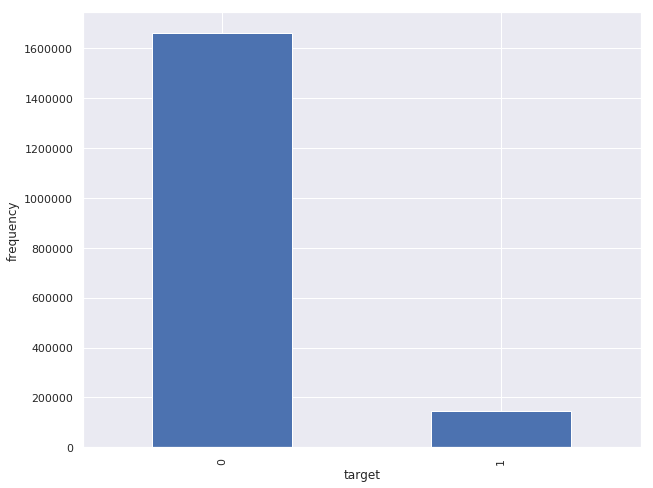

In [0]:
target = data_boolean['target']
fig_std=(10,8)
width = 0.4
target.value_counts().plot(kind='bar', figsize=fig_std).set(xlabel='target', ylabel='frequency') # To see the distribution of 'target' in the data

297.2343266067327 269.1966399585827 1906


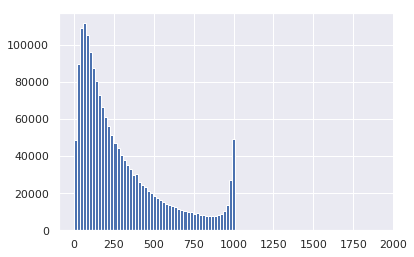

In [0]:
lens = data_boolean.comment_text.str.len()
print(lens.mean(), lens.std(), lens.max())
lens.hist(bins=100)

In [0]:
# X, y = data_boolean["comment_text"], data_boolean["target"]
# train_data, dev_data, train_labels, dev_labels = train_test_split(X, y, test_size=0.2, random_state=42, stratify = y)
# print('train_data shape: ',train_data.shape)
# print('train_labels shape: ',train_labels.shape)
# print('dev_data shape: ',dev_data.shape)
# print('dev_labels shape: ',dev_labels.shape)

## Read Data

In [0]:
train_df, validate_df = train_test_split(data_boolean, test_size=0.2)
print('%d train comments, %d validate comments' % (len(train_df), len(validate_df)))

1443899 train comments, 360975 validate comments


In [0]:


# # Create a text tokenizer.
# tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
# tokenizer.fit_on_texts(data_boolean[TEXT_COLUMN])

# All comments must be truncated or padded to be the same length.
MAX_SEQUENCE_LENGTH = 220
def pad_text(texts, tokenizer):
    return pad_sequences(tokenizer.texts_to_sequences(texts), maxlen=MAX_SEQUENCE_LENGTH)

In [0]:
# import pickle

 
# pickle.dump( tokenizer, open( "/content/drive/My Drive/Jigsaw/tokenizer.p", "wb" ) )

In [0]:
import pickle

tokenizer = pickle.load( open( "/content/drive/My Drive/Jigsaw/tokenizer.p", "rb" ) )

# Train

In [0]:
train_df, test_df = train_test_split(data_boolean, test_size=0.2)
X, y = train_df, train_df["target"]
train_df, validate_df, train_labels, validate_labels = train_test_split(X, y, test_size=0.25, random_state=42, stratify = y)


In [0]:
print(train_df.shape)
print(test_df.shape)
print(validate_df.shape)

(1082924, 48)
(360975, 48)
(360975, 48)


In [0]:
test_df.to_csv(r'/content/drive/My Drive/Jigsaw/7_13_test_df')


## TFIDF

In [0]:
train_data = train_df['comment_text']
dev_data = validate_df['comment_text']
train_labels = train_df['target']
dev_labels = validate_df['target']


In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

train_vectorizer = TfidfVectorizer()
train_vectors = train_vectorizer.fit_transform(train_data)

dev_vectorizer = TfidfVectorizer()
dev_vectorizer.fit(train_data)
dev_vectors = dev_vectorizer.transform(dev_data)

In [0]:
# Get R ratio
log_reg = LogisticRegression(C=100)
log_reg.fit(train_vectors, train_labels)
#y_pred = log_reg.predict(dev_vectors)
validate_df['TFIDF'] = log_reg.predict(dev_vectors)



## LSTM

In [0]:
EMBEDDINGS_PATH = '/content/drive/My Drive/Jigsaw/glove.6B.50d.txt'
EMBEDDINGS_DIMENSION = 50
DROPOUT_RATE = 0.3
LEARNING_RATE = 0.00005
NUM_EPOCHS = 3
BATCH_SIZE = 256

def train_model(train_df, validate_df, tokenizer):
    # Prepare data
    train_text = pad_text(train_df[TEXT_COLUMN], tokenizer)
    train_labels = to_categorical(train_df[TOXICITY_COLUMN])
    validate_text = pad_text(validate_df[TEXT_COLUMN], tokenizer)
    validate_labels = to_categorical(validate_df[TOXICITY_COLUMN])

    # Load embeddings
    print('loading embeddings')
    embeddings_index = {}
    with open(EMBEDDINGS_PATH) as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs

    embedding_matrix = np.zeros((len(tokenizer.word_index) + 1,
                                 EMBEDDINGS_DIMENSION))
    num_words_in_embedding = 0
    for word, i in tokenizer.word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            num_words_in_embedding += 1
            # words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector

    # Create model layers.
    def get_convolutional_neural_net_layers():
        """Returns (input_layer, output_layer)"""
        sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
        embedding_layer = Embedding(len(tokenizer.word_index) + 1,
                                    EMBEDDINGS_DIMENSION,
                                    weights=[embedding_matrix],
                                    input_length=MAX_SEQUENCE_LENGTH,
                                    trainable=False)
        x = embedding_layer(sequence_input)       
        x =  LSTM(50,dropout=0.1,recurrent_dropout=0.1)(x)
        x =  Dense(50,activation = 'relu')(x)
        preds = Dense(2, activation='softmax')(x)
        return sequence_input, preds

    # Compile model.
    print('compiling model')
    input_layer, output_layer = get_convolutional_neural_net_layers()
    model = Model(input_layer, output_layer)
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['acc'])

    # Train model.
    print('training model')
    model.fit(train_text,
              train_labels,
              batch_size=BATCH_SIZE,
              epochs=NUM_EPOCHS,
              validation_data=(validate_text, validate_labels),
              verbose=2)

    return model
train_start_time = time.time()
model = train_model(train_df, validate_df, tokenizer)
train_stop_time = time.time()

model.save('/content/drive/My Drive/Jigsaw/AZ_keras_LSTM_glove_50D.h5')

loading embeddings


W0719 01:36:50.042071 140545159346048 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0719 01:36:50.058441 140545159346048 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0719 01:36:50.076493 140545159346048 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0719 01:36:50.096241 140545159346048 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0719 01:36:50.097519 1405451593

compiling model


W0719 01:36:52.240460 140545159346048 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
W0719 01:36:52.808318 140545159346048 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0719 01:36:52.841021 140545159346048 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


training model
Train on 1082924 samples, validate on 360975 samples
Epoch 1/3
 - 2254s - loss: 0.1871 - acc: 0.9347 - val_loss: 0.1618 - val_acc: 0.9421
Epoch 2/3
 - 2231s - loss: 0.1627 - acc: 0.9419 - val_loss: 0.1550 - val_acc: 0.9439
Epoch 3/3


In [0]:
print("Start time = " + str(train_start_time))
print("End time = " + str(train_end_time))

###Predict

In [0]:
from keras.models import load_model



# Returns a compiled model identical to the previous one
model = load_model(DRIVE_PATH + '/AZ_keras_LSTM_glove_50D.h5')

W0727 19:25:12.213337 140311078848384 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0727 19:25:12.272556 140311078848384 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0727 19:25:12.274663 140311078848384 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0727 19:25:12.389213 140311078848384 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0727 19:25:12.398241 

In [0]:

test_df = pd.read_csv("/content/drive/My Drive/Jigsaw/predicted_LSTM.csv")


In [0]:
validate_df['target'].head()
#validate_df[MODEL_NAME].head()

# Evaluation

## Overall AUC

In [0]:
def calculate_overall_auc(df, model_name):
    true_labels = df[TOXICITY_COLUMN]
    predicted_labels = df[model_name]
    return metrics.roc_auc_score(true_labels, predicted_labels)

### TFIDF

In [0]:
calculate_overall_auc(validate_df, 'TFIDF')

0.7479277689613887

### LSTM

In [0]:
calculate_overall_auc(test_df, 'LSTM')

0.9271866950495042

## Subgroup AUCs

In [0]:
# From baseline kernel

def calculate_overall_auc(df, model_name):
    true_labels = df[TOXICITY_COLUMN]>0.5
    predicted_labels = df[model_name]
    return metrics.roc_auc_score(true_labels, predicted_labels)

def power_mean(series, p):
    total = sum(np.power(series, p))
    return np.power(total / len(series), 1 / p)

def get_final_metric(bias_df, overall_auc, POWER=-5, OVERALL_MODEL_WEIGHT=0.25):
    bias_score = np.average([
        power_mean(bias_df[SUBGROUP_AUC], POWER),
        power_mean(bias_df[BPSN_AUC], POWER),
        power_mean(bias_df[BNSP_AUC], POWER)
    ])
    return (OVERALL_MODEL_WEIGHT * overall_auc) + ((1 - OVERALL_MODEL_WEIGHT) * bias_score)



SUBGROUP_AUC = 'subgroup_auc'
BPSN_AUC = 'bpsn_auc'  # stands for background positive, subgroup negative
BNSP_AUC = 'bnsp_auc'  # stands for background negative, subgroup positive

def compute_auc(y_true, y_pred):
    try:
        return metrics.roc_auc_score(y_true, y_pred)
    except ValueError:
        return np.nan

def compute_subgroup_auc(df, subgroup, label, model_name):
    subgroup_examples = df[df[subgroup]>0.5]
    return compute_auc((subgroup_examples[label]>0.5), subgroup_examples[model_name])

def compute_bpsn_auc(df, subgroup, label, model_name):
    """Computes the AUC of the within-subgroup negative examples and the background positive examples."""
    subgroup_negative_examples = df[(df[subgroup]>0.5) & (df[label]<=0.5)]
    non_subgroup_positive_examples = df[(df[subgroup]<=0.5) & (df[label]>0.5)]
    examples = subgroup_negative_examples.append(non_subgroup_positive_examples)
    return compute_auc(examples[label]>0.5, examples[model_name])

def compute_bnsp_auc(df, subgroup, label, model_name):
    """Computes the AUC of the within-subgroup positive examples and the background negative examples."""
    subgroup_positive_examples = df[(df[subgroup]>0.5) & (df[label]>0.5)]
    non_subgroup_negative_examples = df[(df[subgroup]<=0.5) & (df[label]<=0.5)]
    examples = subgroup_positive_examples.append(non_subgroup_negative_examples)
    return compute_auc(examples[label]>0.5, examples[model_name])

def compute_bias_metrics_for_model(dataset,
                                   subgroups,
                                   model,
                                   label_col,
                                   include_asegs=False):
    """Computes per-subgroup metrics for all subgroups and one model."""
    records = []
    for subgroup in subgroups:
        record = {
            'subgroup': subgroup,
            'subgroup_size': len(dataset[dataset[subgroup]>0.5])
        }
        record[SUBGROUP_AUC] = compute_subgroup_auc(dataset, subgroup, label_col, model)
        record[BPSN_AUC] = compute_bpsn_auc(dataset, subgroup, label_col, model)
        record[BNSP_AUC] = compute_bnsp_auc(dataset, subgroup, label_col, model)
        records.append(record)
    return pd.DataFrame(records).sort_values('subgroup_auc', ascending=True)

## TFIDF

In [0]:
identity_columns = [ 'male', 'female', 'homosexual_gay_or_lesbian', 'christian', 'jewish', 'muslim', 'black', 'white', 'psychiatric_or_mental_illness']

bias_metrics_tfidf = compute_bias_metrics_for_model(validate_df, identity_columns, 'TFIDF', TOXICITY_COLUMN)
bias_metrics_tfidf

,bnsp_auc,bpsn_auc,subgroup,subgroup_auc,subgroup_size
4,0.690734,0.714965,jewish,0.657135,1558
2,0.724989,0.692336,homosexual_gay_or_lesbian,0.668604,2201
5,0.707699,0.712057,muslim,0.670034,4230
6,0.735535,0.686756,black,0.673535,3073
7,0.746125,0.695294,white,0.692776,5101
3,0.713103,0.742463,christian,0.706582,8155
1,0.727965,0.734265,female,0.712809,10737
0,0.746674,0.731513,male,0.729791,8981
8,0.773214,0.712444,psychiatric_or_mental_illness,0.737829,970


## LSTM

In [0]:
#identity_columns = [ 'male', 'female', 'homosexual_gay_or_lesbian', 'christian', 'jewish', 'muslim', 'black', 'white', 'psychiatric_or_mental_illness']
identity_columns = [ 'male', 'female', 'homosexual_gay_or_lesbian', 'christian', 'jewish', 'muslim', 'black', 'white', 'psychiatric_or_mental_illness']

bias_metrics_lstm = compute_bias_metrics_for_model(test_df, identity_columns, 'LSTM', TOXICITY_COLUMN)
bias_metrics_lstm

,bnsp_auc,bpsn_auc,subgroup,subgroup_auc,subgroup_size
2,0.928068,0.745785,homosexual_gay_or_lesbian,0.783509,2272
6,0.928336,0.737537,black,0.787611,2940
7,0.929408,0.723254,white,0.804868,5125
5,0.928626,0.780782,muslim,0.822530,4231
4,0.927553,0.833555,jewish,0.849884,1544
1,0.929073,0.861100,female,0.868347,10741
8,0.927318,0.869708,psychiatric_or_mental_illness,0.869549,966
0,0.929035,0.847946,male,0.870323,9015
3,0.927853,0.897743,christian,0.888441,8062


In [0]:
bias_metrics_lstm.sort_values(by=['subgroup_auc'], ascending=False)

,bnsp_auc,bpsn_auc,subgroup,subgroup_auc,subgroup_size
3,0.927853,0.897743,christian,0.888441,8062
0,0.929035,0.847946,male,0.870323,9015
8,0.927318,0.869708,psychiatric_or_mental_illness,0.869549,966
1,0.929073,0.861100,female,0.868347,10741
4,0.927553,0.833555,jewish,0.849884,1544
5,0.928626,0.780782,muslim,0.822530,4231
7,0.929408,0.723254,white,0.804868,5125
6,0.928336,0.737537,black,0.787611,2940
2,0.928068,0.745785,homosexual_gay_or_lesbian,0.783509,2272


# Extra EDA

## Wordcloud

In [0]:
from wordcloud import WordCloud, STOPWORDS

stopwords = set(STOPWORDS)

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=50,
        max_font_size=40, 
        scale=5,
        random_state=1
    ).generate(str(data))

    fig = plt.figure(1, figsize=(10,10))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

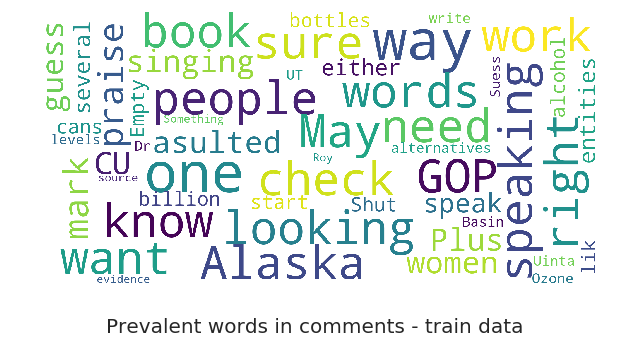

In [0]:
show_wordcloud(train_df['comment_text'].sample(20000), title = 'Prevalent words in comments - train data')

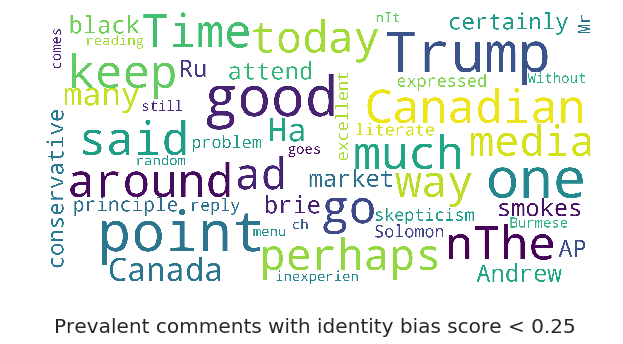

In [0]:
show_wordcloud(data_boolean_idharm.loc[data_boolean_idharm['identity_harm'] < 0.25]['comment_text'].sample(20000), 
               title = 'Prevalent comments with identity bias score < 0.25')

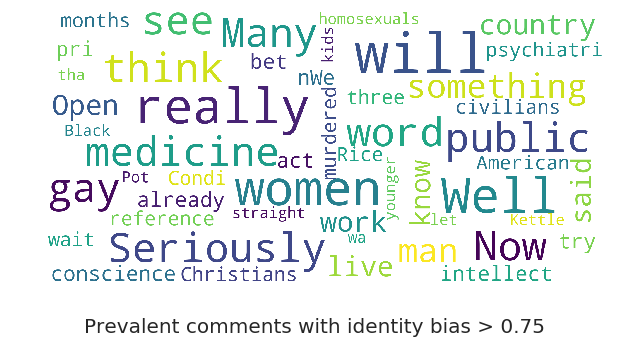

In [0]:
show_wordcloud(data_boolean_idharm.loc[data_boolean_idharm['identity_harm'] > 0.75]['comment_text'].sample(20000), 
               title = 'Prevalent comments with identity bias > 0.75')

## Histogram

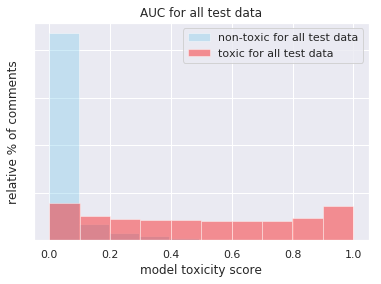

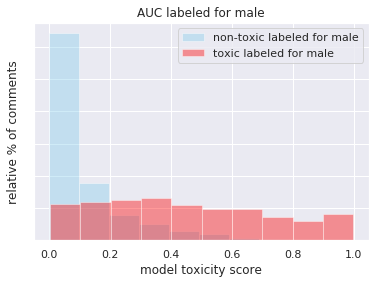

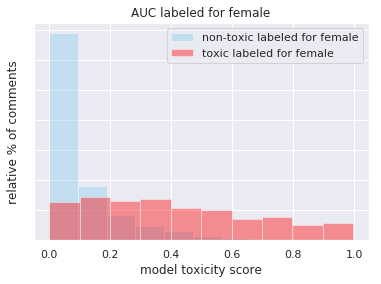

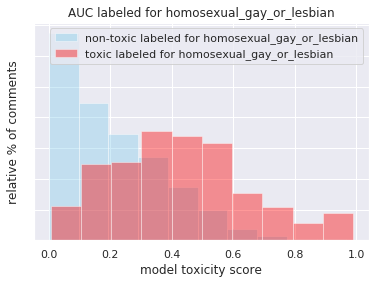

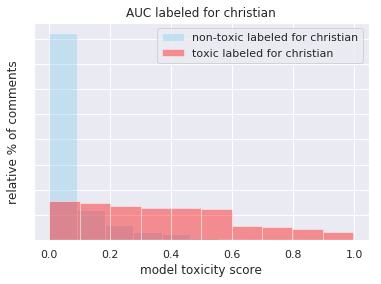

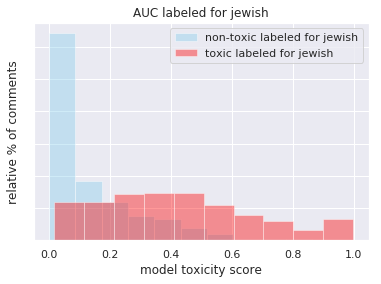

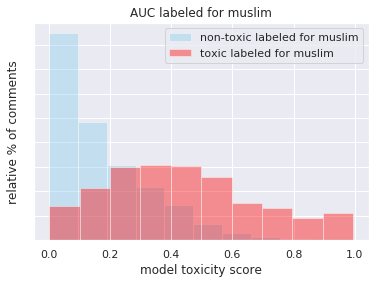

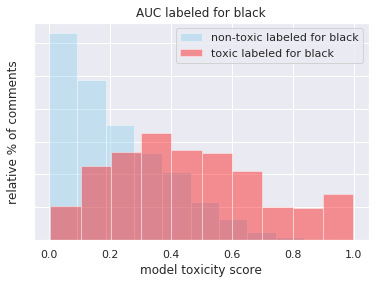

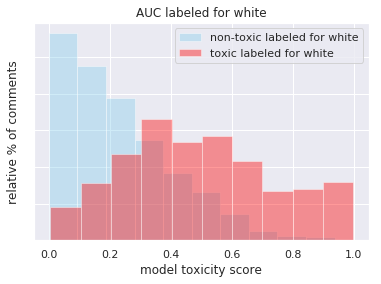

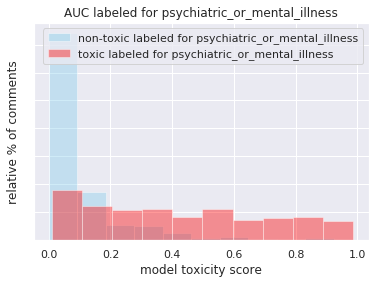

<Figure size 432x288 with 0 Axes>

In [0]:
def plot_histogram(non_toxic_scores, toxic_scores, description):
  NUM_BINS=10
  sns.distplot(non_toxic_scores, norm_hist=True, bins=NUM_BINS, color="skyblue", label='non-toxic ' + description, kde=False)
  ax = sns.distplot(toxic_scores, norm_hist=True, bins=NUM_BINS, color="red", label='toxic ' + description, kde=False)
  ax.set(xlabel='model toxicity score', ylabel='relative % of comments', yticklabels=[], title='AUC ' + description)
  plt.legend()
  plt.figure()

# Plot toxicity distributions of different identities to visualize bias.
def plot_histogram_for_identity(df, identity):
  toxic_scores = df.query(identity + ' == True & target == True')[MODEL_NAME]
  non_toxic_scores = df.query(identity + ' == True & target == False')[MODEL_NAME]
  plot_histogram(non_toxic_scores, toxic_scores, 'labeled for ' + identity)

def plot_background_histogram(df):
  toxic_scores = df.query('target == True')[MODEL_NAME]
  non_toxic_scores = df.query('target == False')[MODEL_NAME]
  plot_histogram(non_toxic_scores, toxic_scores, 'for all test data')

MODEL_NAME = 'LSTM'
# Plot the histogram for the background data, and for a few identities
plot_background_histogram(test_df)
for i in identity_columns:
   plot_histogram_for_identity(test_df, i)
# plot_histogram_for_identity(test_df, 'heterosexual')
# plot_histogram_for_identity(test_df, 'transgender')
# plot_histogram_for_identity(test_df, 'homosexual_gay_or_lesbian')
# plot_histogram_for_identity(test_df, 'atheist')
# plot_histogram_for_identity(test_df, 'christian')
# plot_histogram_for_identity(test_df, 'asian')

In [0]:
plt.figure(figsize=(12,6))
plt.title("Distribution of target in the train set")
sns.distplot(data_boolean['target'],kde=True,hist=False, bins=120, label='target')
plt.legend(); plt.show()

## Features Distribution

In [0]:
def plot_features_distribution(features, title):
    plt.figure(figsize=(12,6))
    plt.title(title)
    for feature in features:
        sns.distplot(data_boolean.loc[~data_boolean[feature].isnull(),feature],kde=True,hist=False, bins=120, label=feature)
    plt.xlabel('')
    plt.legend()
    plt.show()

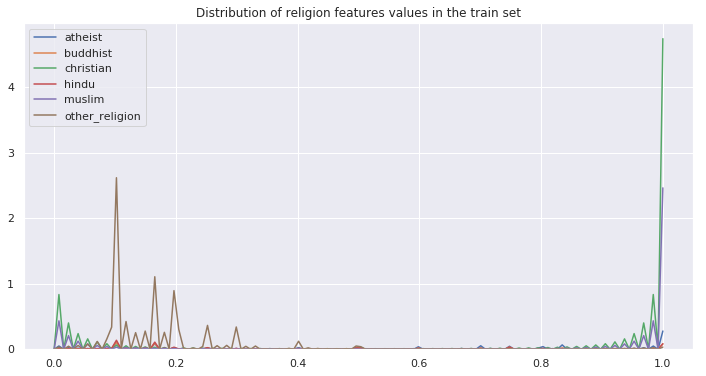

In [0]:
features = ['atheist','buddhist',  'christian', 'hindu', 'muslim', 'other_religion']
plot_features_distribution(features, "Distribution of religion features values in the train set")

# Experiments (Errors)

In [0]:
MAX_NUM_WORDS = 10000
TOXICITY_COLUMN = 'target'
TEXT_COLUMN = 'comment_text'


def calculate_overall_auc(df, model_name):
    true_labels = df[TOXICITY_COLUMN]
    predicted_labels = df[model_name]
    return metrics.roc_auc_score(true_labels, predicted_labels)
  
calculate_overall_auc(test_df, 'LSTM')

0.9271866950495042

In [0]:
false_pos = []
false_neg = []

for i in range(10000):
  if (test_df.loc[i][TOXICITY_COLUMN] == 0 and test_df.loc[i]['LSTM'] >= 0.5):
    false_pos.append(test_df.loc[i][TEXT_COLUMN])
  elif test_df.loc[i][TOXICITY_COLUMN] == 1 and test_df.loc[i]['LSTM'] < 0.5:
    false_neg.append(test_df.loc[i][TEXT_COLUMN])    

## False Negatives

In [0]:
for j in range(10):
  print("Text #" + str(j))
  print(false_neg[j])

Text #0
This cant be real, can it? You think you have heard and seen it all but then all of a sudden this, just sick peope we have in this country!
Text #1
As reported on Canadian TV news last night, Alexandre Bissonnette is an introvert and was influenced by Right Wing French Presidential candidate Le Pen and Donald Trump's bigotry to kill 6 Muslims in back and injury many others during prayers in a mosque in Quebec City. 
Later in the same broadcast strangely WH spokesman said this event supports the US action to ban some Muslims countries. What a disconnect from reality and facts!
Text #2
Calling people Fascist is a habit of people who know nothing about history and can't articulate their thoughts.  I refrained from calling Obama Fascist when he tried to bypass Congress and rule by executive orders, though I was tempted.
Text #3
Sounds like the same progress that was made in OR. since Dems took over.  Everything is rosier because they saved us from the mean, nasty, bigoted Republica

## False Positives (LSTM Said Toxic, but not)

In [0]:
for j in range(10):
  print("Text #" + str(j))
  print(false_pos[j])

Text #0
Agreed, this is a crappy headline.  And, calling what happens to them being "persecuted" is an insult to people who are truly persecuted for beliefs or ideals that aren't easily disprovable nonsense.
Text #1
More interesting information that speaks to the unsavory, moral character of Trump and his ilk. . Got dirt on Hilary ? You get a meeting. Wanna talk about a law? Get in line. I wonder how many "revisions" they will have to file? 
Of course, Trump supporters will defend him to the end. The investigations may or may not turn up something. Maybe he's innocent and just an idiot but not a criminal. But the legitimate investigations will continue...and the more people know the worse it gets. Except for Trump supporters who will defend him to the end.
Text #2
40% undecided voters and Mason is doing a victory lap. 

How can anyone so foolish be taken seriously?
Text #3
This homeowner is just one of those people who invite chaos and controversy into their lives. If he wanted to clut